<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 - AutoEncoder
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [1]:
# Set your student number
student_number = 98105879
Name = 'Ali'
Last_Name = 'Abbasi'

# Rules
- You **are** allowed to add or remove cells.
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [2]:
# remember to save your jupyter file before running this script
from Helper_codes.validator import *

python_code = extract_python("./Q3.ipynb")
with open(f'python_code_Q3_{student_number}.py', 'w') as file:
    file.write(python_code)

your file will be graded


# Autoencoders (25 Points Extra)

<font size=4>
Author: Ahmad Salimi
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

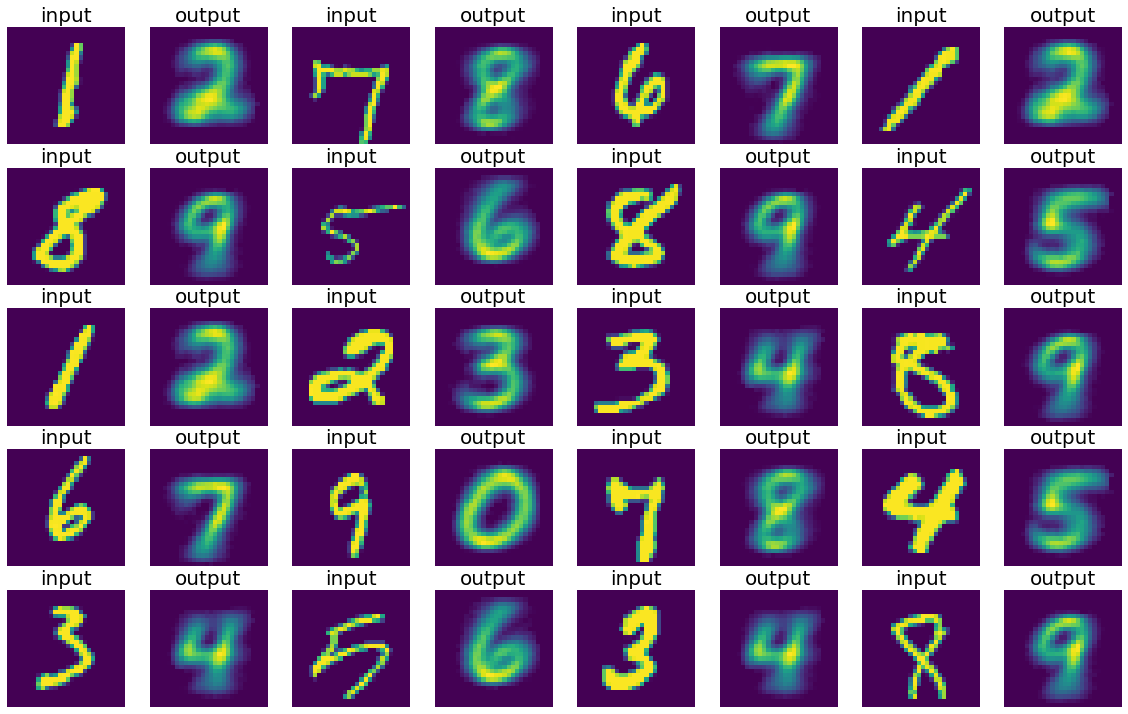

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [3]:
# ! wget https://sut-ai.github.io/resources/problem_sets/rohban_f2021/mini_project/MP4/MPQ4.zip
# ! unzip MPQ4.zip
# ! cp -r Practical/Helper_codes .
# ! rm Theoretical.pdf
# ! rm -r Practical
# ! rm MPQ4.zip

from Helper_codes.ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

--2022-01-02 14:10:58--  https://sut-ai.github.io/resources/problem_sets/rohban_f2021/mini_project/MP4/MPQ4.zip
Resolving sut-ai.github.io (sut-ai.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to sut-ai.github.io (sut-ai.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311027 (304K) [application/zip]
Saving to: ‘MPQ4.zip’

MPQ4.zip            100%[===================>] 303.74K  --.-KB/s    in 0.04s   

2022-01-02 14:10:59 (7.68 MB/s) - ‘MPQ4.zip’ saved [311027/311027]

Archive:  MPQ4.zip
   creating: Practical/
  inflating: __MACOSX/._Practical    
  inflating: Practical/Q1.ipynb      
  inflating: __MACOSX/Practical/._Q1.ipynb  
  inflating: Practical/Q3.ipynb      
   creating: Practical/Helper_codes/
  inflating: __MACOSX/Practical/._Helper_codes  
  inflating: Practical/Q2.ipynb      
  inflating: __MACOSX/Practical/._Q2.ipynb  
  inflating: Practical/Helper_codes/validator.py  
  inflating: __MAC

In [4]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

Examining some of the data:

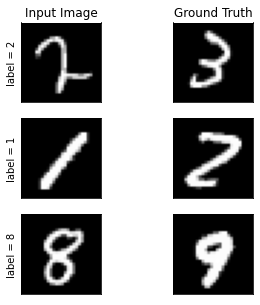

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(5, 5))
for i, idx in enumerate(np.random.choice(len(X), 3, replace=False)):
    img, gt, label = X[idx], Y[idx], y[idx]
    axes[i][0].imshow(img, cmap='gray')
    axes[i][1].imshow(gt, cmap='gray')
    for ax in axes[i]:
        ax.set_xticks([])
        ax.set_yticks([])
    axes[i][0].set_ylabel(f'label = {label}')
axes[0, 0].set_title("Input Image")
axes[0, 1].set_title("Ground Truth");

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, size=784):
        super(AutoEncoder, self).__init__()
        self.input_size = size
        self.dropout = nn.Dropout(0.3)
        self.encoder = nn.Sequential(
            nn.Linear(size, 256),
            nn.ReLU(),
            self.dropout,
            nn.Linear(256, 128),
            nn.ReLU(),
            self.dropout,
            nn.Linear(128, 64),
            nn.ReLU(),
            self.dropout,
            nn.Linear(64, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            self.dropout,
            nn.Linear(64, 128),
            nn.ReLU(),
            self.dropout,
            nn.Linear(128, 256),
            nn.ReLU(),
            self.dropout,
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = x.view(-1, self.input_size)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [18]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [19]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=64,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=256,
    shuffle=False
)

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [37]:
#### INSTANTIATE MODEL AND OPTIMIZER ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder().to(device)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
model

AutoEncoder(
  (dropout): Dropout(p=0.3, inplace=False)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=784, bias=True)
    (10): Sigmoid()
  )
)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [38]:
#### IMPLEMENT TRAIN/VAL LOOP ####
num_epochs = 100
train_loss_arr, val_loss_arr = np.zeros(num_epochs), np.zeros(num_epochs)

val_loss_min = np.Inf

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0

    model.train()
    for data, gt, label in train_dataloader:
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output, gt.to(device).view(-1, 784))
        loss.backward()
        optimizer.step()
        # update running train loss 
        train_loss += loss.item() * len(data)
  
    model.eval()
    for data, gt, label in val_dataloader:
        output = model(data.to(device))
        loss = criterion(output, gt.to(device).view(-1, 784))
        # update running validation loss 
        val_loss += loss.item() * len(data)

    train_loss /= len(train_dataloader.dataset)
    val_loss /= len(val_dataloader.dataset)
    train_loss_arr[epoch] = train_loss
    val_loss_arr[epoch] = val_loss

    if val_loss <= val_loss_min:
        torch.save(model.state_dict(), 'model.pt')
        val_loss_min = val_loss

    lr_scheduler.step()
  
    print(f"[Epoch {epoch}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}")

[Epoch 0]	Train Loss: 0.0836	Validation Loss: 0.0670
[Epoch 1]	Train Loss: 0.0674	Validation Loss: 0.0653
[Epoch 2]	Train Loss: 0.0656	Validation Loss: 0.0640
[Epoch 3]	Train Loss: 0.0635	Validation Loss: 0.0612
[Epoch 4]	Train Loss: 0.0615	Validation Loss: 0.0598
[Epoch 5]	Train Loss: 0.0605	Validation Loss: 0.0591
[Epoch 6]	Train Loss: 0.0598	Validation Loss: 0.0583
[Epoch 7]	Train Loss: 0.0589	Validation Loss: 0.0573
[Epoch 8]	Train Loss: 0.0580	Validation Loss: 0.0565
[Epoch 9]	Train Loss: 0.0574	Validation Loss: 0.0560
[Epoch 10]	Train Loss: 0.0569	Validation Loss: 0.0557
[Epoch 11]	Train Loss: 0.0565	Validation Loss: 0.0555
[Epoch 12]	Train Loss: 0.0563	Validation Loss: 0.0553
[Epoch 13]	Train Loss: 0.0561	Validation Loss: 0.0551
[Epoch 14]	Train Loss: 0.0559	Validation Loss: 0.0550
[Epoch 15]	Train Loss: 0.0557	Validation Loss: 0.0550
[Epoch 16]	Train Loss: 0.0556	Validation Loss: 0.0549
[Epoch 17]	Train Loss: 0.0555	Validation Loss: 0.0549
[Epoch 18]	Train Loss: 0.0554	Validati

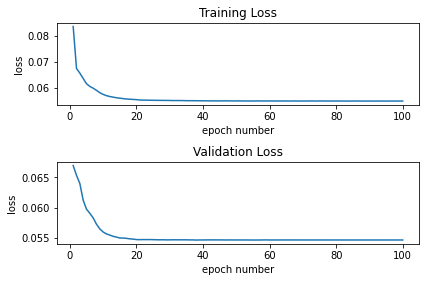

In [39]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(range(1, num_epochs + 1), train_loss_arr)
ax1.set_title('Training Loss')
ax1.set(xlabel='epoch number', ylabel='loss')
ax2.plot(range(1, num_epochs + 1), val_loss_arr)
ax2.set_title('Validation Loss')
ax2.set(xlabel='epoch number', ylabel='loss')
plt.tight_layout(1)

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [40]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
model = AutoEncoder()
model.load_state_dict(torch.load('model.pt'))
model

AutoEncoder(
  (dropout): Dropout(p=0.3, inplace=False)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=784, bias=True)
    (10): Sigmoid()
  )
)

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

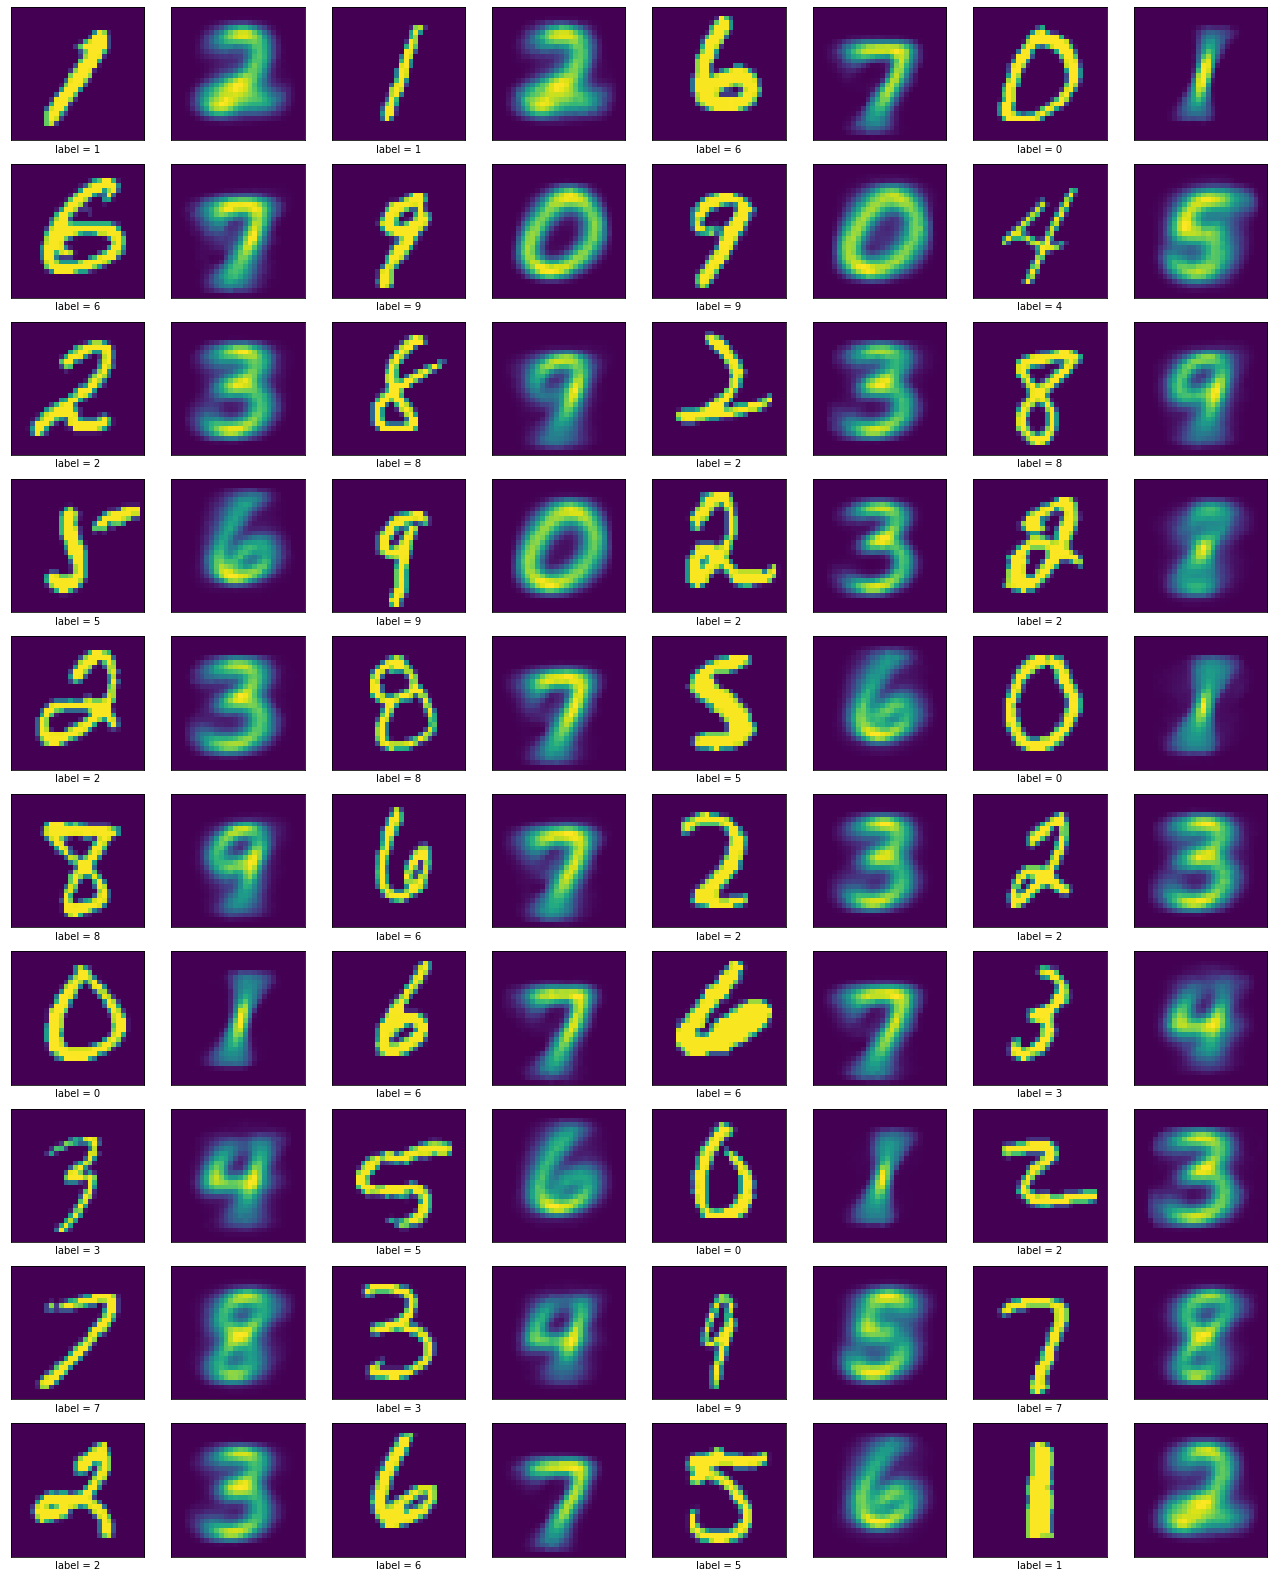

In [45]:
#### VISUALIZE MODEL ####
fig, axes = plt.subplots(10, 8, figsize=(18, 22))
for i in range(10):
    for j in range(0, 8, 2):
        idx = np.random.choice(len(X_test))
        img, gt, label = X_test[idx], Y_test[idx], y_test[idx]
        axes[i][j].imshow(img)
        next = model(torch.from_numpy(img).to(device)).view(28, 28).detach().numpy()
        axes[i][j + 1].imshow(next)
        for ax in axes[i]:
            ax.set_xticks([])
            ax.set_yticks([])
        axes[i][j].set_xlabel(f'label = {label}')
      
plt.tight_layout(1)